 # 프로젝트: ControlNet으로 조건을 준 이미지 생성하기

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/bin/transformers-cli'



In [4]:
# 이미지를 생성하다 보면 CUDA out of memery가 나올 때,메모리 삭제
import torch 
torch.cuda.empty_cache()

## 윤곽선 검출
윤곽선을 검출해 봅시다. ControlNet은 다양한 윤곽선 검출 알고리즘을 제공하지만 가장 유명하고 효과적인 윤곽선 검출 알고리즘인 Canny 알고리즘을 사용함.

먼저 이미지를 불러온다. 


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

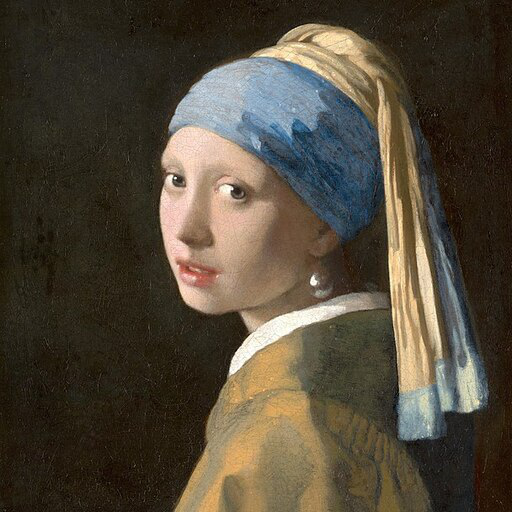

In [5]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

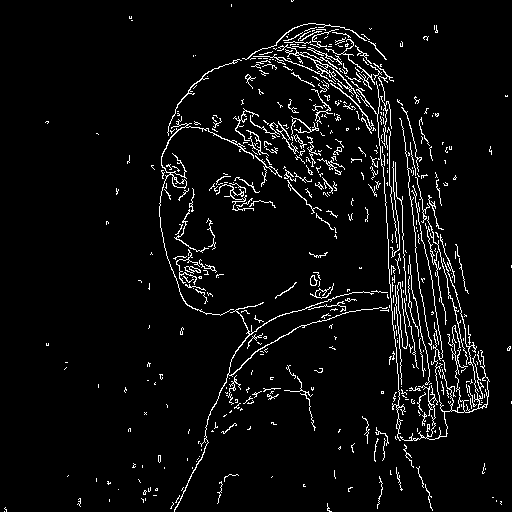

In [6]:
# Open CV를 사용하여 이미지의 윤곽선을 검출한다.
import cv2
from PIL import Image
import numpy as np

# 이미지를 Numpy 배열로 변환
image = np.array(image)

# threshold 지정
low_threshold = 100
high_threshold = 200

# 윤곽선 검출
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis = 2)
canny_image = Image.fromarray(image) # Numpy배열을 PIL 이미지로 변환

canny_image

In [7]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인 불러오기
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

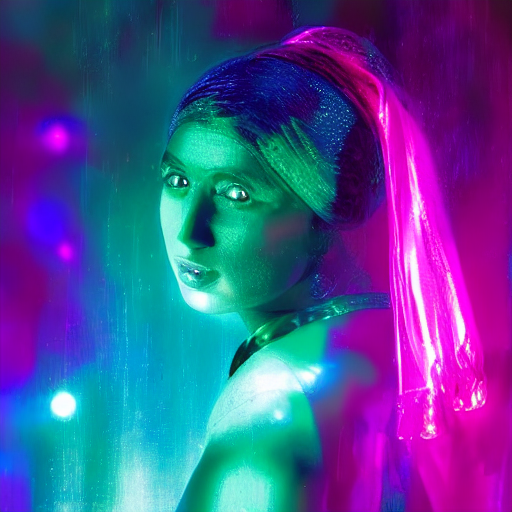

In [9]:
# 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지 생성
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

프롬프트 외에도 부정적인 프롬프트(negative_prompt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있다

- negative_prompt: 원하지 않는 요소를 적을 수 있습니다.
- controlnet_conditioning_scale: ControlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
- num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
- guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.



## 인체 자세 감지

Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기 입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.


In [11]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 42 kB 1.3 MB/s             


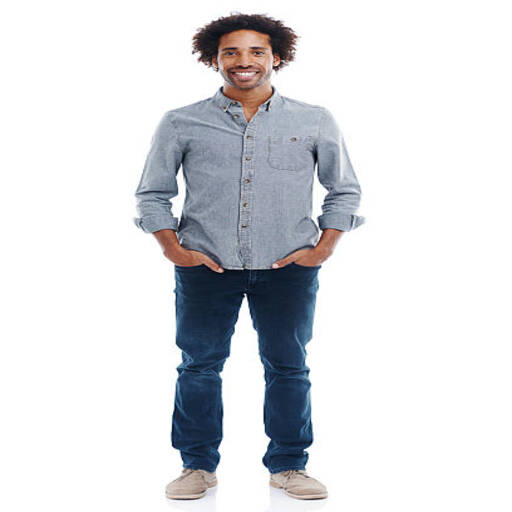

In [12]:
# 먼저 사람의 전신이 담긴 이미지를 불러오기
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


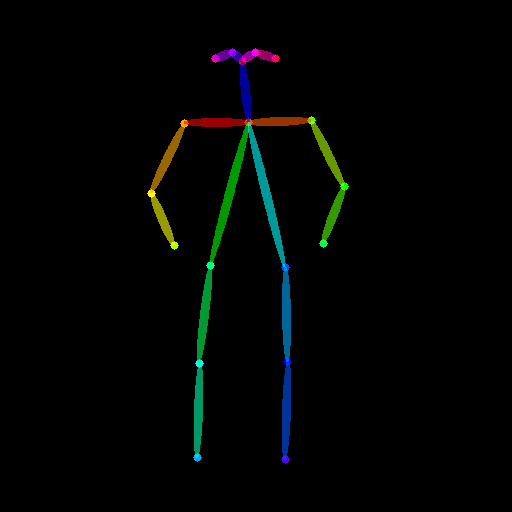

In [13]:
# Openpose 검출기를 사용하면 자세만 추출할 수 있다.
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [14]:
# openpose 전처리기를 사용한 모델 파이프라인을 불러옴
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

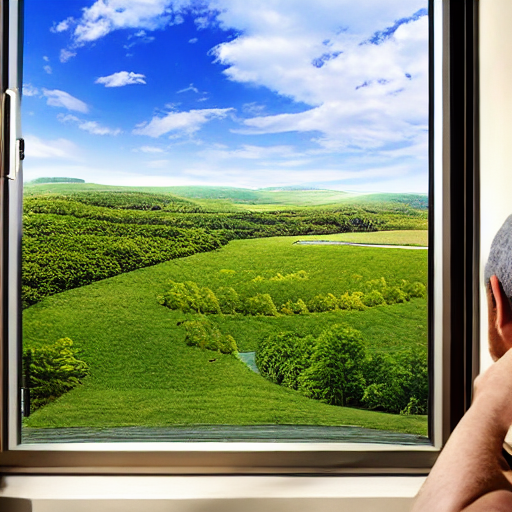

In [37]:
from controlnet_aux import OpenposeDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator =  torch.manual_seed(42)

#프롬프트를 작성합니다. 
prompt =  "A natural landscape depicting a person looking out of a window and gazing at a peaceful landscape."
negative_prompt =  "An angry expression, a dark atmosphere."

images = openpose_image

# 이미지를 생성합니다. 
openpose_image = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=generator,
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image


## 윤곽선 검출 + 인체 자세 감지  

위에서 실습한 2가지의 전처리기를 동시에 사용해 보겠습니다. 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하면 됩니다.

### Canny 알고리즘을 사용한 윤곽선 검출

먼저 Canny 알고리즘으로 윤곽선을 검출합니다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검철 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의해야한다. 



In [61]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

#threshhold를 지정합니다. 
low_threshold = 50
high_threshold = 150

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(image, low_threshold, high_threshold)
canny_image = image[:, :, None]
canny_image = np.concatenate([image, image, image], axis=2)

In [55]:
!pip install IPython

In [69]:
from IPython.display import Image
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image = ("https://8888-w2fk50kakpjaejvhie9e403r8.container-server-prod.aiffel.io/view/aiffel/monariza.jpg")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


ValueError: invalid literal for int() with base 10: 'https://8888-w2fk50kakpjaejvhie9e403r8.container-server-prod.aiffel.io/view/aiffel/monariza.jpg'